In [1]:
import os
import re

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, log_loss, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

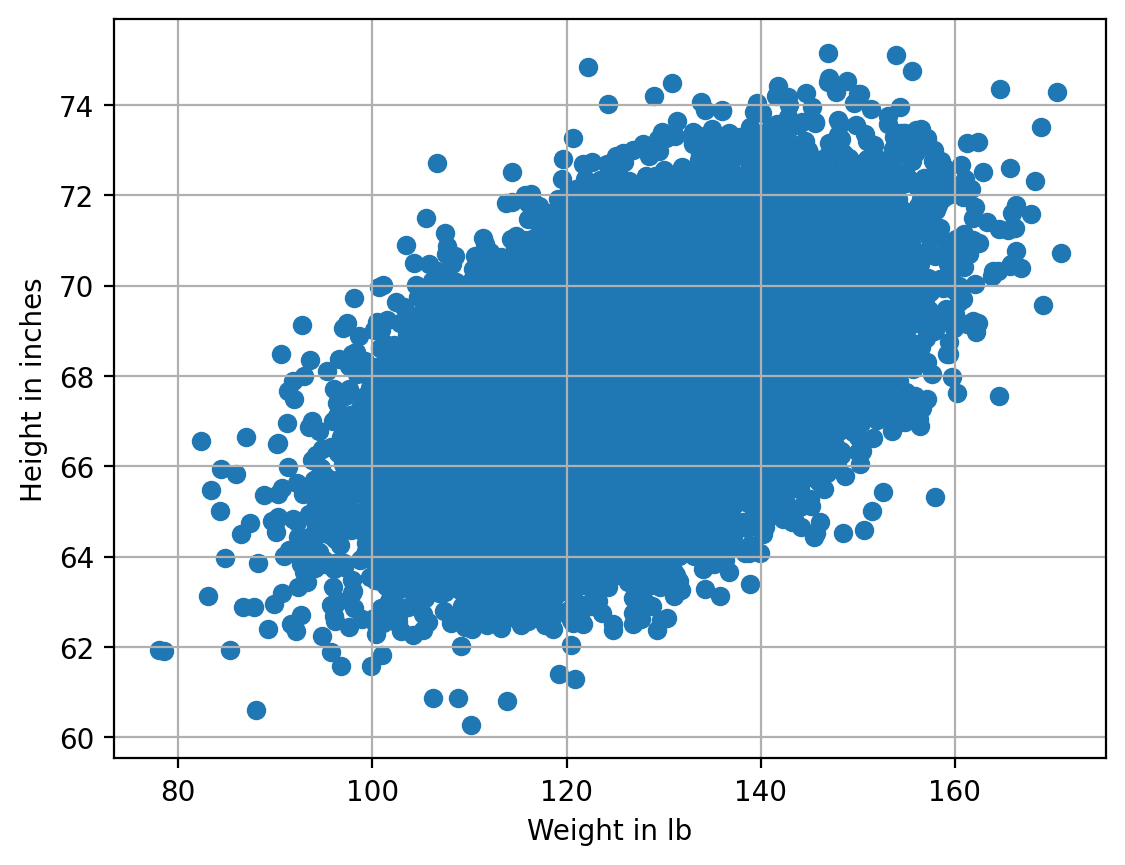

In [3]:
PATH_TO_WRITE_DATA = "../../../data/tmp/"
data_demo = pd.read_csv(os.path.join(DATA_PATH, "weights_heights.csv"))
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.grid()
plt.xlabel("Weight in lb")
plt.ylabel("Height in inches");

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank_train.csv"))
labels = pd.read_csv(
    os.path.join(DATA_PATH, "bank_train_target.csv"), header=None
)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


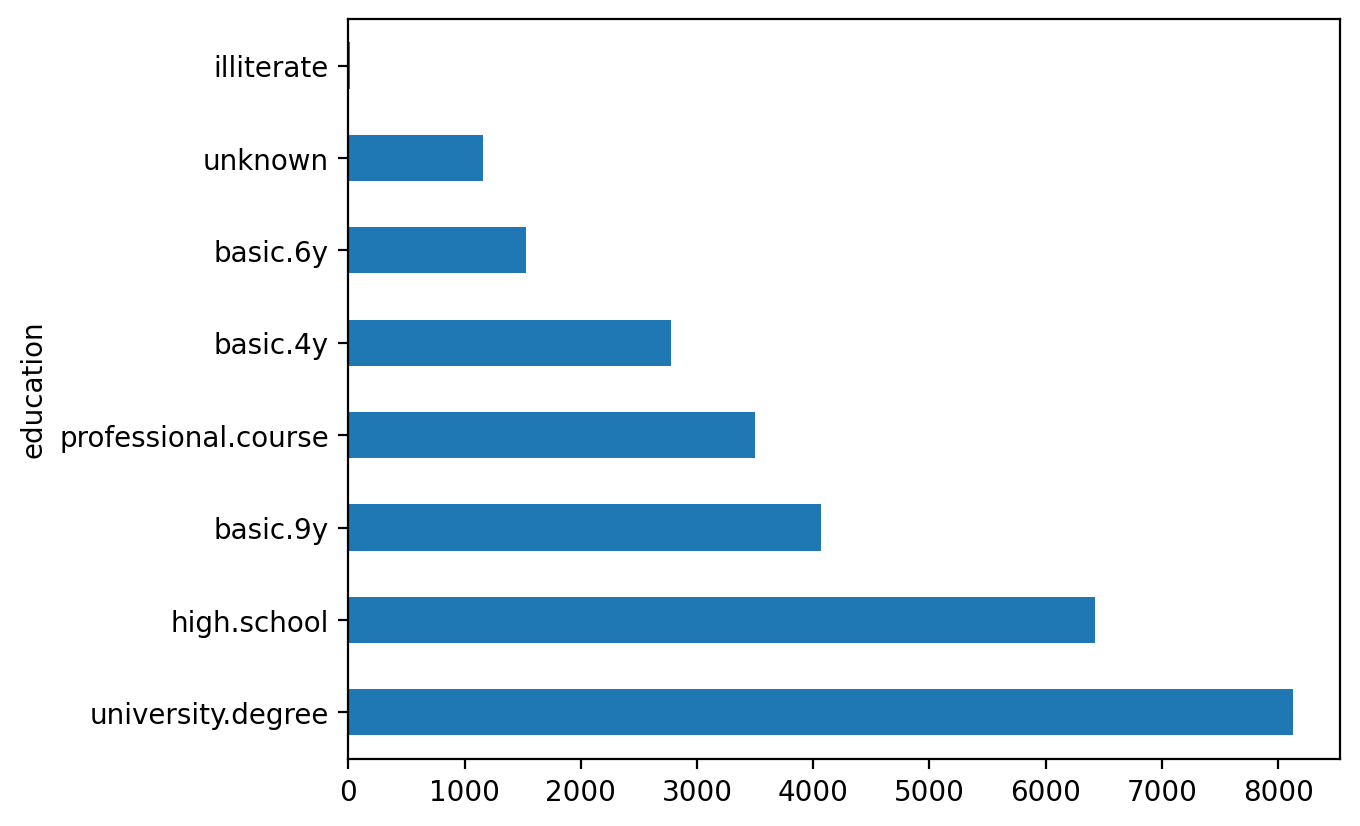

In [6]:
df["education"].value_counts().plot.barh();

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


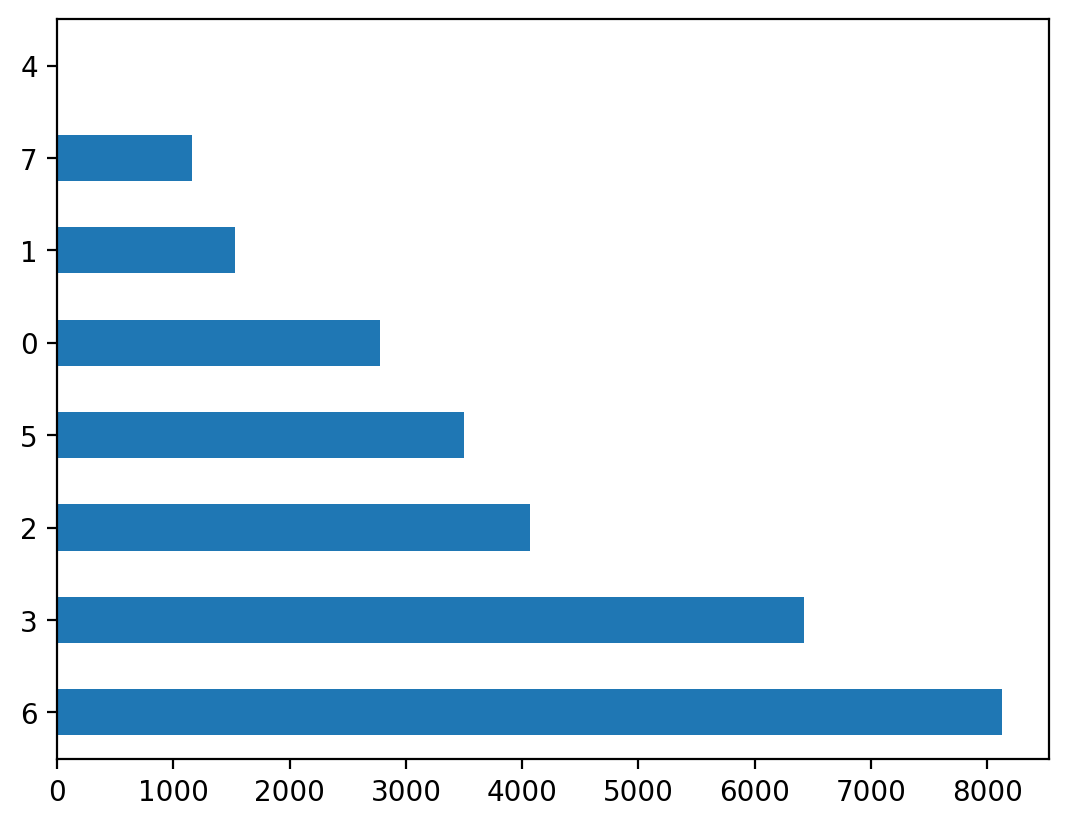

In [7]:
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(df["education"]))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [8]:
df["education"] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [9]:
categorical_columns = df.columns[df.dtypes == "object"].union(["education"])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [10]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels
    )

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))


print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6092
           1       0.00      0.00      0.00       807

    accuracy                           0.88      6899
   macro avg       0.44      0.50      0.47      6899
weighted avg       0.78      0.88      0.83      6899



c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nuke\App

In [7]:
from sklearn.preprocessing import StandardScaler

df = data_demo
scaler = StandardScaler()
X, y = df["Weight"].values, df["Height"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

In [234]:
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

class SGDRegressor(BaseEstimator):
    def __init__(self, eta=0.001, n_epochs=3):
        super().__init__()
        self.eta = eta
        self.n_epochs =  n_epochs
        self.mse_ = []
        self.weights_ = []
        self.w_ = []
    
    def get_epochs(self):
        return self.n_epochs
    
    def get_w(self):
        return self.w_

    def fit(self, X, y):
        # print(np.ones([X.shape[0], 1]).shape)
        # print(X.shape)
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X.shape[1])
        new_w = []
        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()
                
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self

    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y_pred[i] = self.w_.dot(X[i, :])
        return y_pred

In [235]:
sgd = SGDRegressor()

In [236]:
sgd.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:21<00:00,  7.01s/it]


SGDRegressor()

In [254]:
y_pred = sgd.predict(X_valid_scaled)

In [249]:
print(sgd.get_w())

[67.9898497   0.94447605]
12626


In [255]:
print(mean_squared_error(y_valid, y_pred))

2.6708681207033784


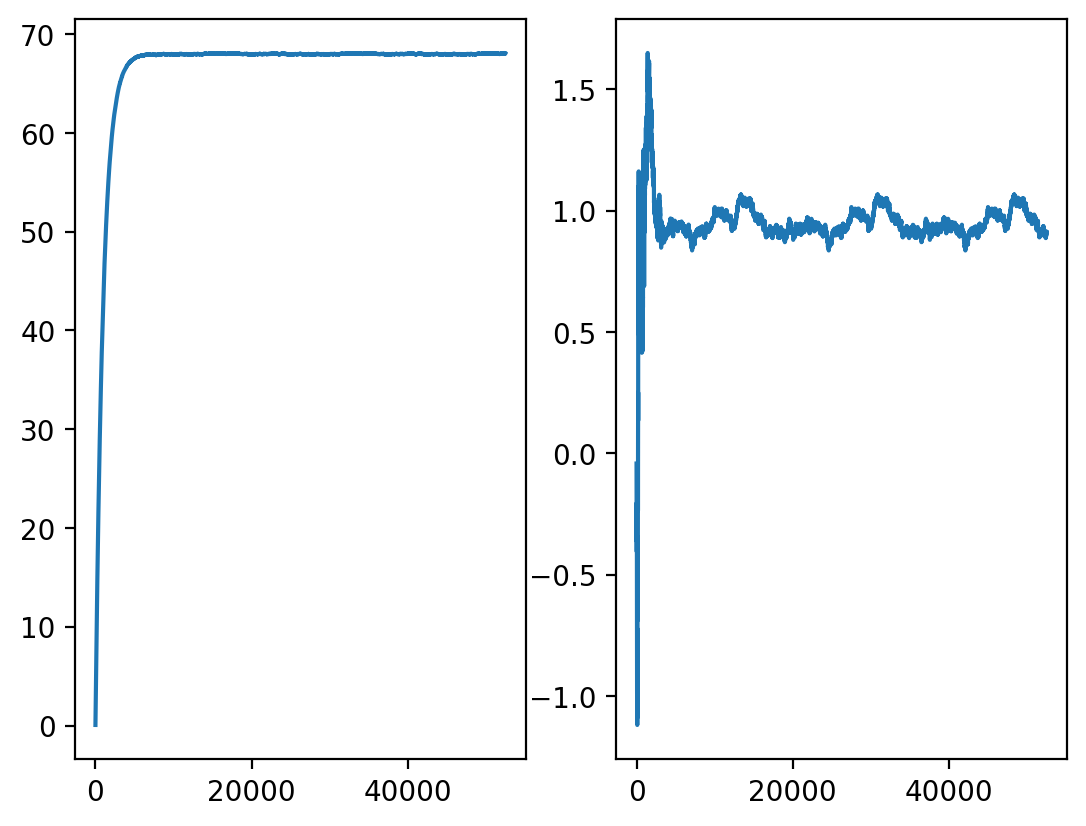

In [250]:
plt.subplot(121)
plt.plot(range(len(sgd.weights_)), [w[0] for w in sgd.weights_])
plt.subplot(122)
plt.plot(range(len(sgd.weights_)), [w[1] for w in sgd.weights_])

In [256]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_valid_scaled)
(lr.coef_)

array([0.94537278])

In [257]:
print(mean_squared_error(y_valid, y_pred))

2.670830767667635
